## Problem Statement

### Context:

Bike-sharing systems are a new generation of traditional bike rentals where the whole process from membership, rental and return has become automatic. Through these systems, the user can easily rent a bike from a particular position and return to another position. Currently, there are about over 500 bike-sharing programs around the world which are composed of over 500 thousand bicycles. Today, there exists a great interest in these systems due to their important role in traffic, environmental, and health issues.


### Objective:
'Travel Along' is a new bike-sharing company and wants to expand its customer count and provide better services at a reasonable cost. They have conducted several surveys and collated the data about weather, weekends, holidays, etc. from the past 2 years.

As a recently hired data scientist at 'Travel Along', you have been asked to analyze the patterns in the data and figure out the key areas which can help the organization to grow and manage the customer demands. Further, you need to use this information to predict the count of bikes shared so that the company can take prior decisions for surge hours.
- What are the different factors which affect the target variable? What business recommendations can we give based on the analysis?

### Data Description:

The bike-sharing rental process is highly correlated to the environmental and seasonal settings. For instance, weather conditions, precipitation, the day of week, season, the hour of the day, etc. can affect the rental behaviors.

- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : whether the day is holiday or not
- weekday : day of the week
- workingday : if day is neither weekend nor holiday then 1, otherwise is 0.
- weathersit : 
	- 1: Clear, Few clouds, Partly cloudy
	- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
	- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
	- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are divided by 41 (max)
- atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max). The “feel like” temperature relies on environmental data including the ambient air temperature, relative humidity, and wind speed to determine how weather conditions feel to bare skin.
- hum: Normalized humidity. The values are divided by 100 (max)
- windspeed: Normalized wind speed. The values are divided by 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

## Importing necessary libraries

**Let's start by importing libraries we need.**

In [85]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np   
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor,RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split

## Data Preprocessing  for machine learning

### Outlier Detection and Treatment

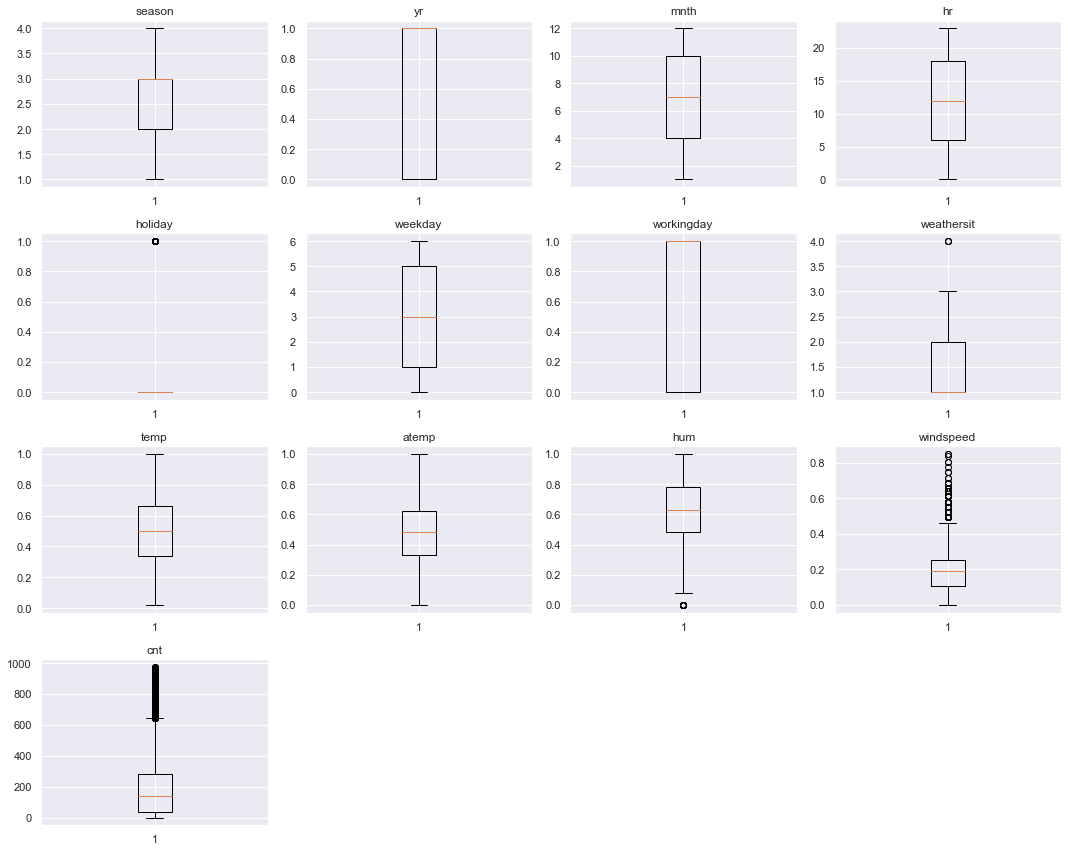

In [86]:
# outlier detection using boxplot
numeric_columns = data.select_dtypes(include=np.number).columns.tolist()


plt.figure(figsize=(15, 12))

for i, variable in enumerate(numeric_columns):
    plt.subplot(4, 4, i + 1)
    plt.boxplot(data[variable], whis=1.5)
    plt.tight_layout()
    plt.title(variable)

plt.show()

- There are quite a few outliers in the data.
- However, we will not treat them as they are proper values.

**Actions for data pre-processing:**

* As count is the addition of two columns - Casual and registered, we can drop these two columns because if we have casual and registered count then making a model won't make sense as we can simply add them.

* We would not have these 2 columns while predicting new observations

In [31]:
#Dropping columns - casual and registered
data.drop(columns=['casual','registered'], inplace=True)

### Data Preparataion for model building

In [32]:
# Separating features and the target column
X = data.drop('cnt', axis=1)
y = data['cnt']

In [33]:
# Splitting the data into train and test sets in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, shuffle=True)

In [34]:
X_train.shape, X_test.shape

((12165, 12), (5214, 12))

- We have 12,165 observations in the train set and 5,214 observations in the test set.

## Bagging - Model Building and Hyperparameter Tuning

- We'll fit different models on the train data and observe their performance. 
- We'll try to improve that performance by tuning some hyperparameters available for that algorithm.
- We'll use GridSearchCv for hyperparameter tuning and `r_2 score` to optimize the model.
- R-square - `Coefficient of determination` is used to evaluate the performance of a regression model. It is the amount of the variation in the output dependent attribute which is predictable from the input independent variables.
- Let's start by creating a function to get model scores, so that we don't have to use the same codes repeatedly.

In [35]:
# function to compute adjusted R-squared
def adj_r2_score(predictors, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = predictors.shape[0]
    k = predictors.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# function to compute MAPE
def mape_score(targets, predictions):
    return np.mean(np.abs(targets - predictions) / targets) * 100


# function to compute different metrics to check performance of a regression model
def model_performance_regression(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance

    model: regressor
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)

    r2 = r2_score(target, pred)  # to compute R-squared
    adjr2 = adj_r2_score(predictors, target, pred)  # to compute adjusted R-squared
    rmse = np.sqrt(mean_squared_error(target, pred))  # to compute RMSE
    mae = mean_absolute_error(target, pred)  # to compute MAE
    mape = mape_score(target, pred)  # to compute MAPE

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "RMSE": rmse,
            "MAE": mae,
            "R-squared": r2,
            "Adj. R-squared": adjr2,
            "MAPE": mape,
        },
        index=[0],
    )

    return df_perf

In [36]:
##  Function to calculate r2_score and RMSE on train and test data
def get_model_score(model, flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_r2=metrics.r2_score(y_train,pred_train)
    test_r2=metrics.r2_score(y_test,pred_test)
    train_rmse=np.sqrt(metrics.mean_squared_error(y_train,pred_train))
    test_rmse=np.sqrt(metrics.mean_squared_error(y_test,pred_test))
    
    #Adding all scores in the list
    score_list.extend((train_r2,test_r2,train_rmse,test_rmse))
    
    # If the flag is set to True then only the following print statements will be dispayed, the default value is True
    if flag==True: 
        print("R-sqaure on training set : ",metrics.r2_score(y_train,pred_train))
        print("R-square on test set : ",metrics.r2_score(y_test,pred_test))
        print("RMSE on training set : ",np.sqrt(metrics.mean_squared_error(y_train,pred_train)))
        print("RMSE on test set : ",np.sqrt(metrics.mean_squared_error(y_test,pred_test)))
    
    # returning the list with train and test scores
    return score_list

### Decision Tree Model

In [37]:
dtree=DecisionTreeRegressor(random_state=1)
dtree.fit(X_train,y_train)

DecisionTreeRegressor(random_state=1)

In [38]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [39]:
dtree_model_train_perf=model_performance_regression(dtree, X_train,y_train)
print("Training performance \n",dtree_model_train_perf)

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.442409  0.005754   0.999994        0.999994  0.004256


In [40]:
dtree_model_test_perf=model_performance_regression(dtree, X_test,y_test)
print("Testing performance \n",dtree_model_test_perf)

Testing performance 
         RMSE        MAE  R-squared  Adj. R-squared      MAPE
0  60.827833  35.107787   0.892227        0.891979  38.03325


- The Decision tree model with default parameters is overfitting the train data.
- Let's see if we can reduce overfitting and improve performance on test data by tuning hyperparameters.

### Hyperparameter Tuning

In [41]:
# Choose the type of classifier. 
dtree_tuned = DecisionTreeRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': list(np.arange(2,20)) + [None], 
              'min_samples_leaf': [1, 3, 5, 7, 10],
              'max_leaf_nodes' : [2, 3, 5, 10, 15] + [None],
              'min_impurity_decrease': [0.001, 0.01, 0.1, 0.0]
             }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(dtree_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
dtree_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
dtree_tuned.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=14, min_impurity_decrease=0.1,
                      min_samples_leaf=5, random_state=1)

In [42]:
dtree_tuned_model_train_perf = model_performance_regression(dtree_tuned, X_train,y_train)
print("Training performance \n",dtree_model_train_perf)

Training performance 
        RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  0.442409  0.005754   0.999994        0.999994  0.004256


In [43]:
dtree_tuned_model_test_perf = model_performance_regression(dtree_tuned, X_test,y_test)
print("Testing performance \n",dtree_tuned_model_test_perf)

Testing performance 
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  54.969957  31.841364   0.911985        0.911782  38.356397


- The overfitting is reduced after hyperparameter tuning and the test score has increased by approx 2%.
- RMSE is also reduced on test data and the model is generalizing better than the decision tree model with default parameters.

**Plotting the feature importance of each variable**

In [44]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(dtree_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                 Imp
hr          0.634942
temp        0.117441
yr          0.079271
workingday  0.063920
season      0.022164
atemp       0.019463
weathersit  0.019460
hum         0.017227
mnth        0.010498
weekday     0.010009
windspeed   0.003882
holiday     0.001724


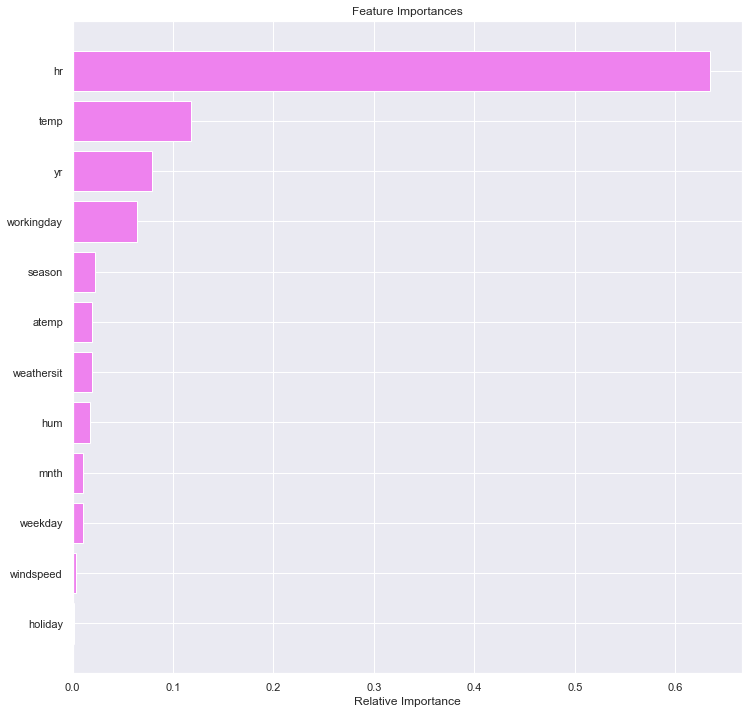

In [45]:
feature_names = X_train.columns
importances = dtree_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- hr is the most important feature, in addition to temp and yr, for tuned decision tree model

### Random Forest Model

In [46]:
rf_estimator=RandomForestRegressor(random_state=1)
rf_estimator.fit(X_train,y_train)

RandomForestRegressor(random_state=1)

In [47]:
rf_estimator_model_train_perf = model_performance_regression(rf_estimator, X_train,y_train)
print("Training performance \n",rf_estimator_model_train_perf)

Training performance 
         RMSE       MAE  R-squared  Adj. R-squared       MAPE
0  16.167421  9.641324   0.991902        0.991894  11.757327


In [48]:
rf_estimator_model_test_perf = model_performance_regression(rf_estimator, X_test,y_test)
print("Testing performance \n",rf_estimator_model_test_perf)

Testing performance 
        RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  44.56215  26.192368   0.942159        0.942026  32.748634


- Random forest is giving a good r2 score of 94% on the test data but it is slightly overfitting the train data.
- Let's try to reduce this overfitting by hyperparameter tuning.

### Hyperparameter Tuning

In [49]:
# Choose the type of classifier. 
rf_tuned = RandomForestRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {  
                'max_depth':[4, 6, 8, 10, None],
                'max_features': ['sqrt','log2',None],
                'n_estimators': [80, 90, 100, 110, 120]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(rf_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
rf_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
rf_tuned.fit(X_train, y_train)

RandomForestRegressor(max_features=None, n_estimators=120, random_state=1)

In [50]:
rf_tuned_model_train_perf = model_performance_regression(rf_tuned, X_train, y_train)
print("Training performance \n",rf_tuned_model_train_perf)

Training performance 
         RMSE       MAE  R-squared  Adj. R-squared      MAPE
0  16.160093  9.622604    0.99191        0.991902  11.73432


In [51]:
rf_tuned_model_test_perf = model_performance_regression(rf_tuned, X_test, y_test)
print("Testing performance \n",rf_tuned_model_test_perf)

Testing performance 
       RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  44.5806  26.202363   0.942111        0.941977  32.734172


- No significant change in the result. The result is almost the same before or after the hyperparameter tuning.

In [52]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(rf_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                 Imp
hr          0.610116
temp        0.121773
yr          0.076295
workingday  0.059489
hum         0.026844
weathersit  0.020962
season      0.020876
atemp       0.020670
mnth        0.016153
weekday     0.013539
windspeed   0.010510
holiday     0.002774


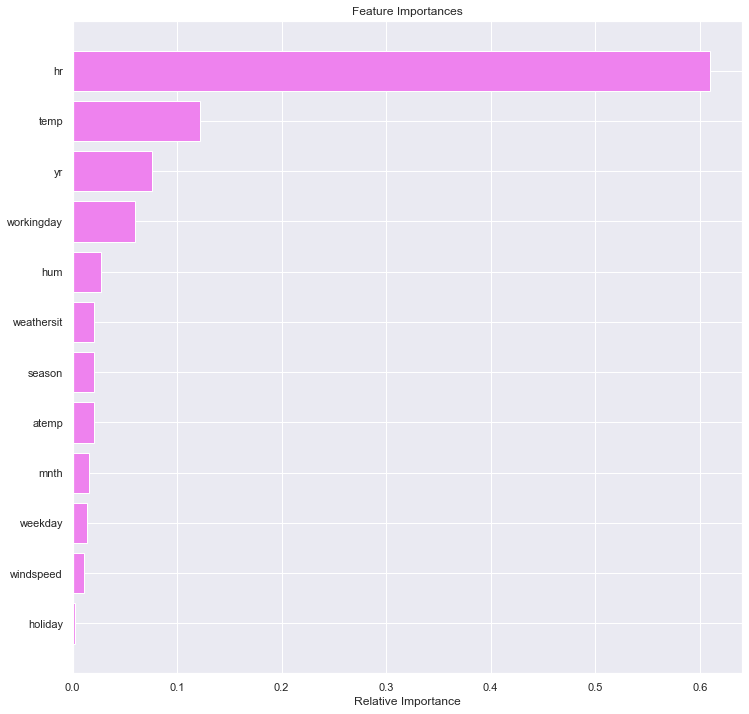

In [53]:
feature_names = X_train.columns
importances = rf_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- hr is the most important feature, in addition to temp and yr, for the tuned random forest model.

## Boosting - Model Building and Hyperparameter Tuning

### AdaBoost Regressor

In [54]:
ab_regressor=AdaBoostRegressor(random_state=1)
ab_regressor.fit(X_train,y_train)

AdaBoostRegressor(random_state=1)

In [55]:
ab_regressor_model_train_perf = model_performance_regression(ab_regressor, X_train,y_train)
print("Training performance \n",ab_regressor_model_train_perf)

Training performance 
          RMSE        MAE  R-squared  Adj. R-squared        MAPE
0  104.441843  80.996029   0.662067        0.661733  185.877344


In [56]:
ab_regressor_model_test_perf = model_performance_regression(ab_regressor, X_test,y_test)
print("Testing performance \n",ab_regressor_model_test_perf)

Testing performance 
          RMSE        MAE  R-squared  Adj. R-squared        MAPE
0  105.415729  81.468364   0.676321        0.675574  196.403082


- AdaBoost is generalizing well but it is giving poor performance, in terms of r2 score as well as RMSE, as compared to the decision tree and random forest model.  

### Hyperparameter Tuning

In [57]:
# Choose the type of classifier. 
ab_tuned = AdaBoostRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(10,100,10), 
              'learning_rate': [1, 0.1, 0.5, 0.01],
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(ab_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
ab_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
ab_tuned.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=1, n_estimators=30, random_state=1)

In [58]:
ab_tuned_model_train_perf = model_performance_regression(ab_tuned, X_train,y_train)
print("Training performance \n",ab_tuned_model_train_perf)

Training performance 
          RMSE        MAE  R-squared  Adj. R-squared        MAPE
0  103.326379  80.468809   0.669247         0.66892  195.189129


In [59]:
ab_tuned_model_test_perf = model_performance_regression(ab_tuned, X_test,y_test)
print("Testing performance \n",ab_tuned_model_train_perf)

Testing performance 
          RMSE        MAE  R-squared  Adj. R-squared        MAPE
0  103.326379  80.468809   0.669247         0.66892  195.189129


- We can see that there is no significant improvement in the model after hyperparameter tuning.

In [60]:
# importance of features in the tree building

print(pd.DataFrame(ab_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                 Imp
hr          0.523674
yr          0.135837
atemp       0.076841
workingday  0.058274
season      0.049087
weathersit  0.047040
hum         0.046359
mnth        0.036370
temp        0.026518
holiday     0.000000
weekday     0.000000
windspeed   0.000000


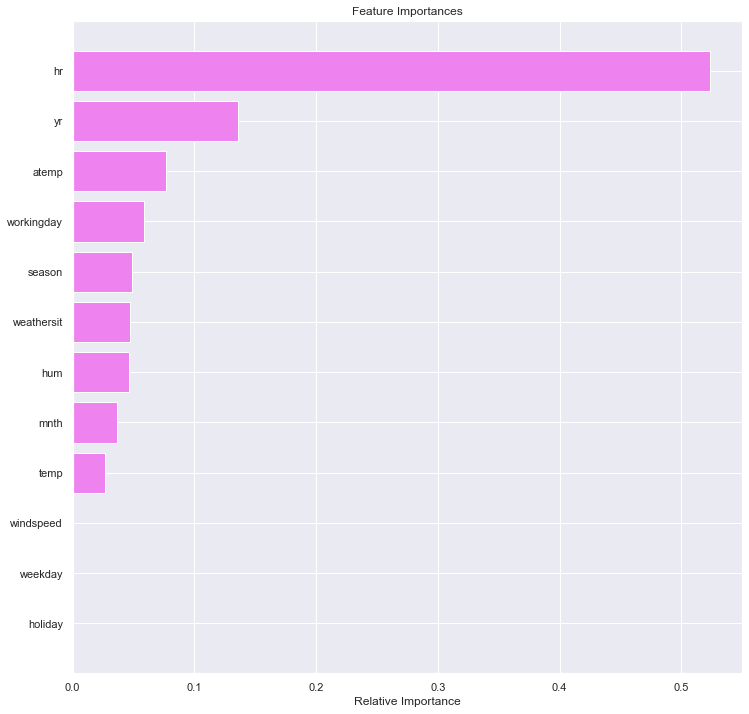

In [61]:
feature_names = X_train.columns
importances = ab_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- hr is the most important feature here, followed by yr and atemp.

### Gradient Boosting Regressor

In [62]:
gb_estimator=GradientBoostingRegressor(random_state=1)
gb_estimator.fit(X_train,y_train)

GradientBoostingRegressor(random_state=1)

In [63]:
gb_estimator_model_train_perf = model_performance_regression(gb_estimator, X_train,y_train)
print("Training performance \n",gb_estimator_model_train_perf)

Training performance 
        RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  71.87459  48.518039   0.839959        0.839801  92.152544


In [64]:
gb_estimator_model_test_perf = model_performance_regression(gb_estimator, X_test, y_test)
print("Testing performance \n",gb_estimator_model_test_perf)

Testing performance 
         RMSE        MAE  R-squared  Adj. R-squared        MAPE
0  74.173279  49.691124    0.83975         0.83938  100.149788


- Gradient boosting is generalizing well and giving decent results but not as good as random forest.

### Hyperparameter Tuning

In [65]:
# Choose the type of classifier. 
gb_tuned = GradientBoostingRegressor(random_state=1)

# Grid of parameters to choose from
parameters = {'n_estimators': np.arange(50,200,25), 
              'subsample':[0.7,0.8,0.9,1],
              'max_features':[0.7,0.8,0.9,1],
              'max_depth':[3,5,7,10]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(gb_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
gb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
gb_tuned.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=7, max_features=0.9, n_estimators=175,
                          random_state=1, subsample=0.7)

In [66]:
gb_tuned_model_train_perf = model_performance_regression(gb_tuned, X_train,y_train)
print("Training performance \n",gb_tuned_model_train_perf)

Training performance 
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  22.272348  14.726501   0.984632        0.984617  23.168969


In [67]:
gb_tuned_model_test_perf = model_performance_regression(gb_tuned, X_test, y_test)
print("Testing performance \n",gb_tuned_model_test_perf)

Testing performance 
         RMSE        MAE  R-squared  Adj. R-squared      MAPE
0  39.076262  24.101884   0.955524        0.955421  36.01227


- We can see that the model has improved significantly in terms of r2 score and RMSE.
- The r2 score has increased by approx 12% on the test data.
- RMSE has decreased by more than 30 for the test data.

In [68]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(gb_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                 Imp
hr          0.577712
temp        0.099255
workingday  0.083006
yr          0.081833
atemp       0.046505
hum         0.024214
season      0.024071
weathersit  0.020767
weekday     0.018315
mnth        0.013716
windspeed   0.007647
holiday     0.002959


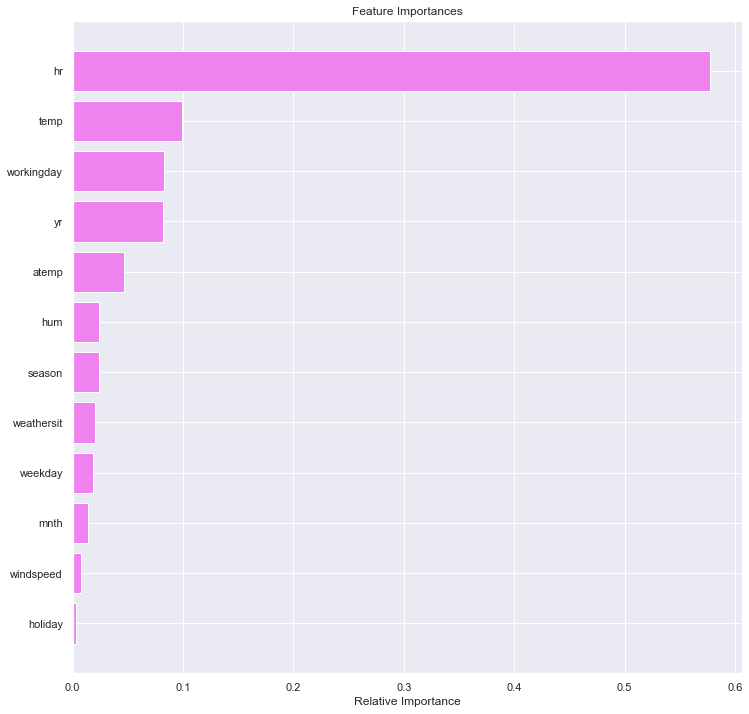

In [69]:
feature_names = X_train.columns
importances = gb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- hr is the most important feature
- temp, yr and workingday have almost equal importance 

### XGBoost Regressor

In [70]:
xgb_estimator=XGBRegressor(random_state=1, verbosity = 0)
xgb_estimator.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [71]:
xgb_estimator_model_train_perf = model_performance_regression(xgb_estimator, X_train, y_train)
print("Training performance \n",xgb_estimator_model_train_perf)

Training performance 
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  27.214945  17.680308   0.977055        0.977032  29.490325


In [72]:
xgb_estimator_model_test_perf = model_performance_regression(xgb_estimator, X_test,y_test)
print("Testing performance \n",xgb_estimator_model_test_perf)

Testing performance 
         RMSE        MAE  R-squared  Adj. R-squared      MAPE
0  41.356427  25.804078   0.950182        0.950067  41.83796


- XGBoost with default parameters is giving almost as good results as the tuned gradient boosting model.

### Hyperparameter Tuning

In [73]:
# Choose the type of classifier. 
xgb_tuned = XGBRegressor(random_state=1, verbosity = 0)

# Grid of parameters to choose from
parameters = {'n_estimators': [75,100,125,150], 
              'subsample':[0.7, 0.8, 0.9, 1],
              'gamma':[0, 1, 3, 5],
              'colsample_bytree':[0.7, 0.8, 0.9, 1],
              'colsample_bylevel':[0.7, 0.8, 0.9, 1]
              }

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.r2_score)

# Run the grid search
grid_obj = GridSearchCV(xgb_tuned, parameters, scoring=scorer,cv=5)
grid_obj = grid_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameters
xgb_tuned = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
xgb_tuned.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=1, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=150, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

In [74]:
xgb_tuned_model_train_perf = model_performance_regression(xgb_tuned, X_train, y_train)
print("Training performance \n",xgb_tuned_model_train_perf)

Training performance 
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  24.198253  15.806928   0.981859        0.981842  28.513527


In [75]:
xgb_tuned_model_test_perf = model_performance_regression(xgb_tuned, X_test, y_test)
print("Testing performance \n",xgb_tuned_model_test_perf)

Testing performance 
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  40.738742  25.837159   0.951659        0.951547  43.831514


In [76]:
# importance of features in the tree building ( The importance of a feature is computed as the 
#(normalized) total reduction of the criterion brought by that feature. It is also known as the Gini importance )

print(pd.DataFrame(xgb_tuned.feature_importances_, columns = ["Imp"], index = X_train.columns).sort_values(by = 'Imp', ascending = False))

                 Imp
workingday  0.289411
hr          0.252782
yr          0.180462
temp        0.082915
season      0.054046
weathersit  0.040526
atemp       0.035576
weekday     0.021362
holiday     0.014707
hum         0.012433
mnth        0.011668
windspeed   0.004111


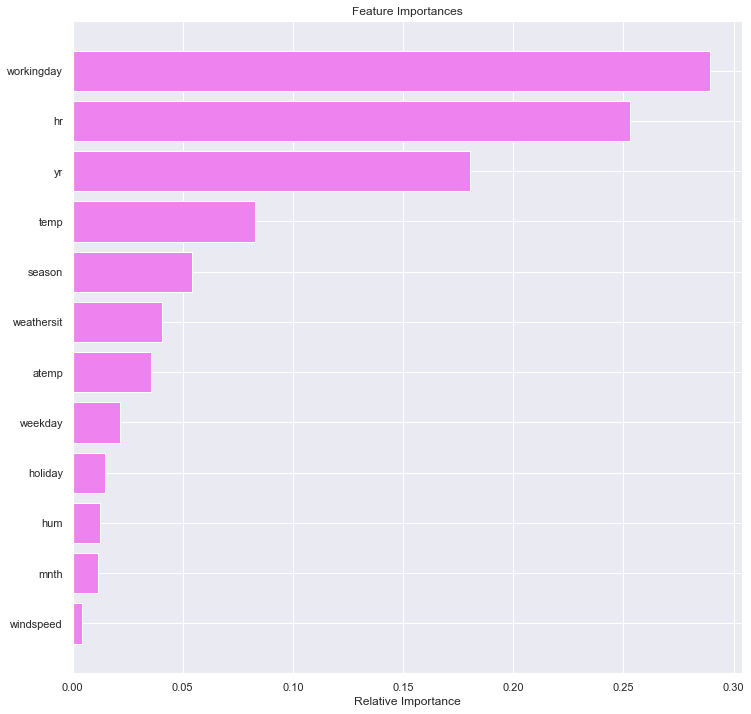

In [77]:
feature_names = X_train.columns
importances = xgb_tuned.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

- In XGBoost, workingday is the most important feature followed by features - hr and yr

## Stacking Model

**Now, let's build a stacking model with the tuned models - decision tree, random forest, and gradient boosting, then use XGBoost to get the final prediction.**

In [78]:
estimators=[('Decision Tree', dtree_tuned),('Random Forest', rf_tuned),
           ('Gradient Boosting', gb_tuned)]
final_estimator=XGBRegressor(random_state=1)

In [79]:
stacking_estimator=StackingRegressor(estimators=estimators, final_estimator=final_estimator,cv=5)
stacking_estimator.fit(X_train,y_train)

StackingRegressor(cv=5,
                  estimators=[('Decision Tree',
                               DecisionTreeRegressor(max_depth=14,
                                                     min_impurity_decrease=0.1,
                                                     min_samples_leaf=5,
                                                     random_state=1)),
                              ('Random Forest',
                               RandomForestRegressor(max_features=None,
                                                     n_estimators=120,
                                                     random_state=1)),
                              ('Gradient Boosting',
                               GradientBoostingRegressor(max_depth=7,
                                                         max_features=0.9,
                                                         n_estimators=175,
                                                         random_state=1,
                              

In [80]:
stacking_estimator_model_train_perf = model_performance_regression(stacking_estimator, X_train, y_train)
print("Training performance \n",stacking_estimator_model_train_perf)

Training performance 
         RMSE        MAE  R-squared  Adj. R-squared      MAPE
0  23.272893  14.272256    0.98322        0.983204  15.89583


In [81]:
stacking_estimator_model_test_perf = model_performance_regression(stacking_estimator, X_test, y_test)
print("Testing performance \n",stacking_estimator_model_test_perf)

Testing performance 
         RMSE        MAE  R-squared  Adj. R-squared       MAPE
0  41.413999  24.715628   0.950043        0.949928  29.427916


## Comparing all models

In [82]:
# training performance comparison

models_train_comp_df = pd.concat(
    [dtree_model_train_perf.T, dtree_tuned_model_train_perf.T, rf_estimator_model_train_perf.T,rf_tuned_model_train_perf.T,
    ab_regressor_model_train_perf.T,ab_tuned_model_train_perf.T,gb_estimator_model_train_perf.T,gb_tuned_model_train_perf.T,
    xgb_estimator_model_train_perf.T,xgb_tuned_model_train_perf.T,stacking_estimator_model_train_perf.T],
    axis=1,
)

models_train_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Adaboost Regressor",
    "Adaboost Tuned",
    "Gradient Boost Estimator",
    "Gradient Boost Tuned",
    "XGB",
    "XGB Tuned",
    "Stacking Classifier"
]

print("Training performance comparison:")
models_train_comp_df

Training performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest Estimator,Random Forest Tuned,Adaboost Regressor,Adaboost Tuned,Gradient Boost Estimator,Gradient Boost Tuned,XGB,XGB Tuned,Stacking Classifier
RMSE,0.442409,36.442792,16.167421,16.160093,104.441843,103.326379,71.874590,22.272348,27.214945,24.198253,23.272893
MAE,0.005754,22.525337,9.641324,9.622604,80.996029,80.468809,48.518039,14.726501,17.680308,15.806928,14.272256
R-squared,0.999994,0.958856,0.991902,0.991910,0.662067,0.669247,0.839959,0.984632,0.977055,0.981859,0.983220
Adj. R-squared,0.999994,0.958816,0.991894,0.991902,0.661733,0.668920,0.839801,0.984617,0.977032,0.981842,0.983204
MAPE,0.004256,28.657314,11.757327,11.734320,185.877344,195.189129,92.152544,23.168969,29.490325,28.513527,15.895830


In [83]:
# Testing performance comparison

models_test_comp_df = pd.concat(
    [dtree_model_test_perf.T, dtree_tuned_model_test_perf.T, rf_estimator_model_test_perf.T,rf_tuned_model_test_perf.T,
    ab_regressor_model_test_perf.T,ab_tuned_model_test_perf.T,gb_estimator_model_test_perf.T,gb_tuned_model_test_perf.T,
    xgb_estimator_model_test_perf.T,xgb_tuned_model_test_perf.T,stacking_estimator_model_test_perf.T],
    axis=1,
)

models_test_comp_df.columns = [
    "Decision Tree",
    "Decision Tree Tuned",
    "Random Forest Estimator",
    "Random Forest Tuned",
    "Adaboost Regressor",
    "Adaboost Tuned",
    "Gradient Boost Estimator",
    "Gradient Boost Tuned",
    "XGB",
    "XGB Tuned",
    "Stacking Classifier"
]

print("Testing performance comparison:")
models_test_comp_df

Testing performance comparison:


,Decision Tree,Decision Tree Tuned,Random Forest Estimator,Random Forest Tuned,Adaboost Regressor,Adaboost Tuned,Gradient Boost Estimator,Gradient Boost Tuned,XGB,XGB Tuned,Stacking Classifier
RMSE,60.827833,54.969957,44.562150,44.580600,105.415729,104.430458,74.173279,39.076262,41.356427,40.738742,41.413999
MAE,35.107787,31.841364,26.192368,26.202363,81.468364,81.015165,49.691124,24.101884,25.804078,25.837159,24.715628
R-squared,0.892227,0.911985,0.942159,0.942111,0.676321,0.682343,0.839750,0.955524,0.950182,0.951659,0.950043
Adj. R-squared,0.891979,0.911782,0.942026,0.941977,0.675574,0.681610,0.839380,0.955421,0.950067,0.951547,0.949928
MAPE,38.033250,38.356397,32.748634,32.734172,196.403082,207.467888,100.149788,36.012270,41.837960,43.831514,29.427916


- The tuned gradient boosting model is the best model here. It has the highest r2 score of approx 95.5% and the lowest RMSE of approx 39 on the test data.
- Gradient boosting, XGBoost, and stacking regressor are the top 3 models. They are all giving a similar performance.

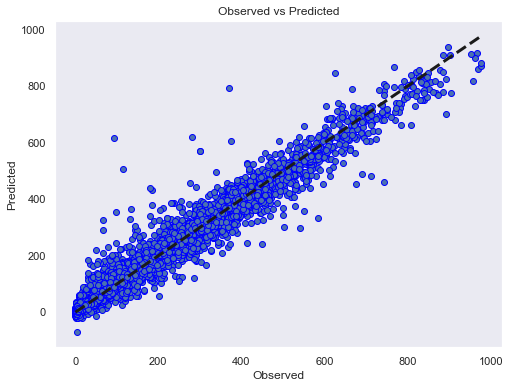

In [84]:
# So plot observed and predicted values of the test data for the best model i.e. tuned gradient boosting model
fig, ax = plt.subplots(figsize=(8, 6))
y_pred=gb_tuned.predict(X_test)
ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')
ax.set_title("Observed vs Predicted")
plt.grid()
plt.show()

- We can see that points are dense on the line where predicted is equal to the observed.
- This implies that most of the predicted values are close to the true values with some exceptions as seen in the plot. 

## Conclusions and Business Recommendations

- We can use this predictive model for any season and environmental parameters (which we know in advance) and can predict the count of the bikes to be rented. The ability to predict the number of hourly users can allow the entities (businesses/governments) that oversee these systems to manage them more efficiently and cost-effectively.
- More bikes can be made available for the fall and winter seasons as the number of bikes rented is high in these seasons.
- As the number of bikes rented is high for day timings compared to night timings, similarly, fall and winter seasons have more surges compared to other seasons. We can choose differential prices of bikes accordingly.
- As most of the rentals are for commuting to workplaces and colleges daily, company can launch more stations near busy workplaces or schools/colleges to reach out to their main customers.
- Number of bikes rented is heavily dependent on the weather. So, we should adjust the number of available bikes in an area based on the weather forecast.
- Maintenance activities for bikes can be done at night due to low usage of bikes during the nighttime.
- Company can provide offers or coupons like a monthly subscription to compensate for the low count on holidays or weekends.